**Voorbereiding: Jupyter Notebook initialiseren**

In [1]:
import sys
sys.path.append('D:/Python/Projecten/pypv/lib')  # add my own lib folder to Python's search path
sys.path.append('D:/Python/Projecten/pypv/datafiles')  # also add the folder with the data files

In [2]:
from IPython.display import Image, HTML
import sun
import photovoltaic as pv
from quantities.date_time import Date, ANY_YEAR

`sun`, `photovoltaic` en `quantities` zijn drie zelf geschreven Python *packages* (*libraries*) die alle programmatuur bevatten om de computer de berekeningen te laten uitvoeren.
* `sun` bevat onder meer de programmacode om horizonprofielen, zonnebaandiagrammen en de zonnebestralingssterkte (irradiantie) op een oppervlak te berekenen.
* `photovoltaic` modelleert de componenten van een fotovoltaïsche installatie (o.a. zonnepaneel, zonnepanelenmatrix, omvormer) en de programmcode om een energieanalyse te maken.
* `quantities` is een secundaire *package* waarin fysische grootheden worden gemodelleerd (o.a. tijd, datum). 

# DEEL 2 | BASISONTWERP VAN DE FOTOVOLTAÏSCHE INSTALLATIE

In deze *notebook* wordt het basisontwerp van een fotovoltaïsche installatie doorlopen.

## Stap 1: Layout van het Zonnepanelenveld

Een mogelijke layout wordt hieronder getoond. De betrachting is in de eerste plaats het beschikbare dakoppervlak zoveel mogelijk te benutten. De oriëntatie van de zonnepanelen is daaraan ondergeschikt.

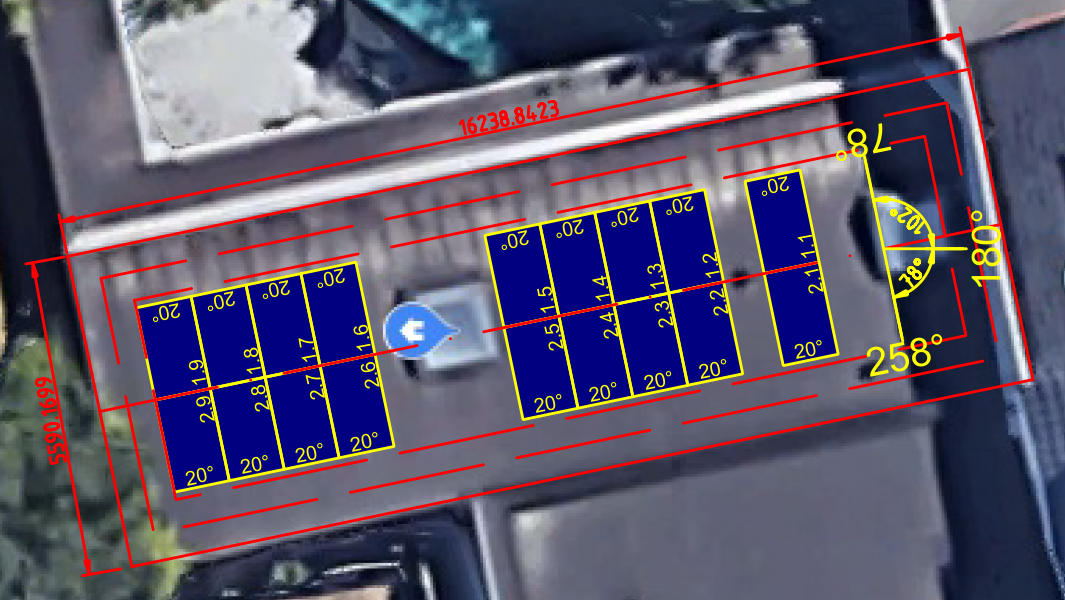

In [3]:
Image('../images/layout.png')

We onderscheiden twee strengen van telkens 9 zonnepanelen. Eén streng is naar het oosten gericht (azimut 78°). De andere streng is naar het westen gericht (azimut 258°). De voorziene hellingshoek van de panelen is 20°.

## Stap 2: Configuratie van de Fotovoltaïsche Matrices

### Keuze en Configuratie van de Zonnepanelen

De berekeningen zijn gebaseerd op een zonnepaneel SHARP NU-RC300|300 W. De fotovoltaïsche parameters kunnen uit de datasheet afgelezen worden. Deze parameters worden gebundeld in een object van de klasse `PhotoVoltaicCharacteristics`. Naast de parameterwaarden onder STC-condities worden aan dit object ook de temperatuurcoëfficiënten doorgegeven en de celtemperatuur onder nominale werkingscondities (NOCT).

In [4]:
pv_char = pv.PhotoVoltaicCharacteristics(
    pv.STC(Isc=9.97, Voc=39.4, Impp=9.63, Vmpp=31.2),
    pv.TemperatureCoefficients(cIsc=0.05, cVoc=-0.29, cPmpp=-0.4),
    noct=48.0
)

In de matrix kunnen we 4 types van zonnepanelen onderscheiden afhankelijk van hun oriëntatie en het horizonprofiel (zie deel 1) waaronder ze vallen:
* zonnepanelen met oostelijke oriëntatie die vallen onder horizonprofiel 1 (vooraan het platte dak)
* zonnepanelen met oostelijke oriëntatie die vallen onder horizonprofiel 2 (achteraan het platte dak)
* zonnepanelen met westelijke oriëntatie die vallen onder horizonprofiel 1
* zonnepanelen met westelijke oriëntatie die vallen onder horizonprofiel 2

We importeren de horizonprofielen (zie deel 1) in de werkomgeving van onderhavige notebook. Ook de locatie van de zonnepanelen dient opnieuw in deze notebook ingegeven te worden.

In [5]:
from horizon_profiles import hp_01, hp_02

loc = sun.Location(
    name='Ghent',
    region='Belgium',
    latitude=51.07,
    longitude=3.69,
    altitude=9.0
)

Vervolgens kunnen we de 4 verschillende types zonnepanelen configureren.

**Zonnepaneel met oostelijke oriëntatie onder horizonprofiel 1**

In [6]:
solar_panel_east_hp01 = pv.SolarPanel(
    loc=loc,
    orient=pv.Orientation(azimuth=78.0, tilt=20.0),
    dim=pv.Dimensions(width=0.99, height=1.66),
    pv_char=pv_char,
    hz_profile=hp_01
)

**Zonnepaneel met oostelijke oriëntatie onder horizonprofiel 2**

In [7]:
solar_panel_east_hp02 = pv.SolarPanel(
    loc=loc,
    orient=pv.Orientation(azimuth=78.0, tilt=20.0),
    dim=pv.Dimensions(width=0.99, height=1.66),
    pv_char=pv_char,
    hz_profile=hp_02
)

**Zonnepaneel met westelijke oriëntatie onder horizonprofiel 1**

In [8]:
solar_panel_west_hp01 = pv.SolarPanel(
    loc=loc,
    orient=pv.Orientation(azimuth=258.0, tilt=20.0),
    dim=pv.Dimensions(width=0.99, height=1.66),
    pv_char=pv_char,
    hz_profile=hp_01
)

**Zonnepaneel met westelijke oriëntatie onder horizonprofiel 2**

In [9]:
solar_panel_west_hp02 = pv.SolarPanel(
    loc=loc,
    orient=pv.Orientation(azimuth=258.0, tilt=20.0),
    dim=pv.Dimensions(width=0.99, height=1.66),
    pv_char=pv_char,
    hz_profile=hp_02
)

### Creatie en Configuratie van de Zonnepanelenmatrices

We zullen de twee strengen van 9 zonnepanelen, die een verschillende oriëntatie hebben, elk als een afzonderlijke matrix beschouwen. Elke matrix zal worden aangesloten op een aparte MPPT-ingang van de omvormer.<br> In het codeblok hieronder worden 2 objecten van de klasse `SolarPanelMatrix` gecreëerd, genaamd `'PVM_EAST'` en `'PVM_WEST'`. De eerste 4 zonnepanelen van elke streng worden gelieerd aan horizonprofiel 1, de 5 overige zonnepanelen worden gelieerd aan horizonprofiel 2.

In [10]:
row_num = 9  # number of solar panels in one string
col_num = 1  # number of strings
solar_panels = [[solar_panel_east_hp01, solar_panel_east_hp02], [solar_panel_west_hp01, solar_panel_west_hp02]]
matrix_names = ('PVM_EAST', 'PVM_WEST')
matrices = []
for i, matrix_name in enumerate(matrix_names):
    matrix = pv.SolarPanelMatrix(matrix_name, row_num=row_num, col_num=col_num)
    matrices.append(matrix)
    for r in range(row_num):
        for c in range(col_num):
            if 0 <= r < 5:
                matrix.add_solar_panel(solar_panels[i][0], r, c)
            if 5 <= r < 9:
                matrix.add_solar_panel(solar_panels[i][1], r, c)

Nu de FV matrices geconfigureerd zijn, kunnen we de parameters onder STC van deze matrices aan het computerprogramma opvragen. De output wordt in HTML opgemaakt.

In [11]:
for matrix in matrices:
    matrix.set_operating_conditions(Gsurf=1000.0, Tcell=25.0)  # set STC conditions
    display(HTML(
        f'<b>Prestaties van de PV matrix "{matrix.id}" onder STC</b><br>'
        '<ul>'
        f'<li>piekvermogen = <b>{matrix.get_mpp_power() / 1000.0:.1f}</b> kWp</li>'
        f'<li>MPP-stroom = <b>{matrix.get_mpp_current():.1f}</b> A</li>'
        f'<li>MPP-spanning = <b>{matrix.get_mpp_voltage():.1f}</b> V</li>'
        f'<li>kortsluitstroom = <b>{matrix.get_sc_current():.1f}</b> A</li>'
        f'<li>openklemspanning = <b>{matrix.get_oc_voltage():.1f}</b> V</li>'
        '</ul>'
    ))

**Vereiste geleidersectie van de strengkabels**

Om de vereiste dwarsdoorsnede (sectie) van de geleiders te kunnen berekenen, moet het computerprogramma eerst de lengte van de solarkabels kennen. Er wordt aangenomen dat beide strengen een kabel met een lengte van 25 m zullen hebben.

In [12]:
for matrix in matrices:
    matrix.string_cables.set_cable_lengths(25)
    cs_min = matrix.string_cables.calc_min_cross_sections()
    display(HTML(f'min. vereiste geleiderdoorsnede voor matrix "{matrix.id}" = <b>{cs_min[0]:.1f}</b> mm²'))

De eerst opvolgende in de handel verkrijgbare geleiderdoorsnede is 4 mm².

In [13]:
for matrix in matrices:
    matrix.string_cables.set_cross_sections(4.0)

## Stap 3: Creatie van de Omvormer

In [14]:
inverter = pv.Inverter(id_='INVERTER')

Nadat het `Inverter` object is gecreëerd, verbinden we deze inverter met de FV matrices:

In [15]:
for matrix in matrices:
    inverter.add_pv_matrix(matrix)

**Bepaling van het vereiste werkingsgebied van de omvormer**<br>
Nu kunnen we aan het computerprogramma het vereiste werkingsgebied van de omvormer opvragen:

In [16]:
inv_req = inverter.get_requirements()
display(HTML(
    "<ul>"
    f"<li>Min. vereist nominaal AC-vermogen: <b>{inv_req['Pac_min'][0] / 1000.0:.3f}</b> kW</li>"
    f"<li>Max. vereist nominaal AC-vermogen: <b>{inv_req['Pac_max'][0] / 1000.0:.3f}</b> kW</li>"
    f"<li>Min. vereist max. DC-vermogen: <b>{inv_req['Pdc_max'][0] / 1000.0:.3f}</b> kW</li>"
    f"<li>Min. vereiste max. DC-spanning (per MPPT-ingang): <b>{inv_req['Vdc_max'][0]:.3f}</b> V</li>"
    f"<li>Max. vereiste min. MPP-spanning (per MPPT-ingang): <b>{inv_req['Vmpp_min'][0]:.3f}</b> V</li>"
    f"<li>Min. vereiste max. DC-stroom (per MPPT-ingang): <b>{inv_req['Idc_max'][0]:.3f}</b> A</li>"
    "</ul>"
))

Het vereiste DC-werkingsgebied van de omvormer kan in een (V,I)-diagram worden voorgesteld samen met een aantal karakteristieke curven van de aangesloten FV matrix, die bepalend zijn voor het vereiste werkingsgebied van de omvormer. Noteer dat de grafiek betrekking heeft op 1 MPPT-ingang van de omvormer.

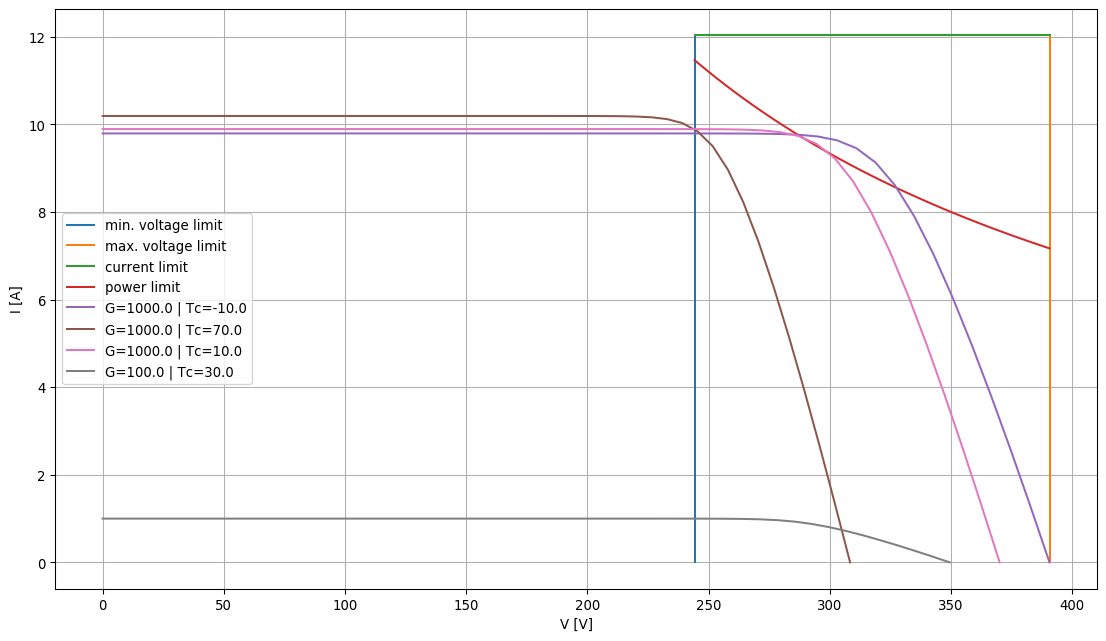

In [17]:
graph = inverter.plot_working_range(required_range=True, fig_size=(14, 8), dpi=96)
graph.show_graph()

## Stap 4: Selectie en Configuratie van de Omvormer

Op basis van de uitkomst van stap 3 kan men een geschikte omvormer selecteren. We selecteren een omvormer *SMA Sunny Boy 5.0* (SB5.0-1AV-40). Met de gegevens uit de datasheet configureren we de omvormer:

In [18]:
inverter.setup(
    Pac_nom=5000.0,
    Vdc_nom=365.0,
    Vdc_max=600.0,
    Vmpp_min=175.0,
    Vmpp_max=500.0,
    Idc_max=15.0,
    Pdc_max=7500.0,
    eff_max=97.0
)

Vervolgens kunnen we het computerprogramma nog vragen om te controleren of de geconfigureerde omvormer over het minimaal vereiste werkingsgebied beschikt:

In [19]:
results = inverter.check()
msg = ''
if results:
    for result in results:
        msg += result + '<br>'
else:
    msg = 'Controle van de omvormer-selectie: <b>OK</b>'
display(HTML(msg))

Het DC-werkingsgebied van de omvormer kan in een (V,I)-diagram worden voorgesteld samen met een aantal karakteristieke curven van de aangesloten FV matrix, die bepalend zijn voor het vereiste werkingsgebied van de omvormer. Noteer dat de grafiek betrekking heeft op 1 MPPT-ingang van de omvormer.

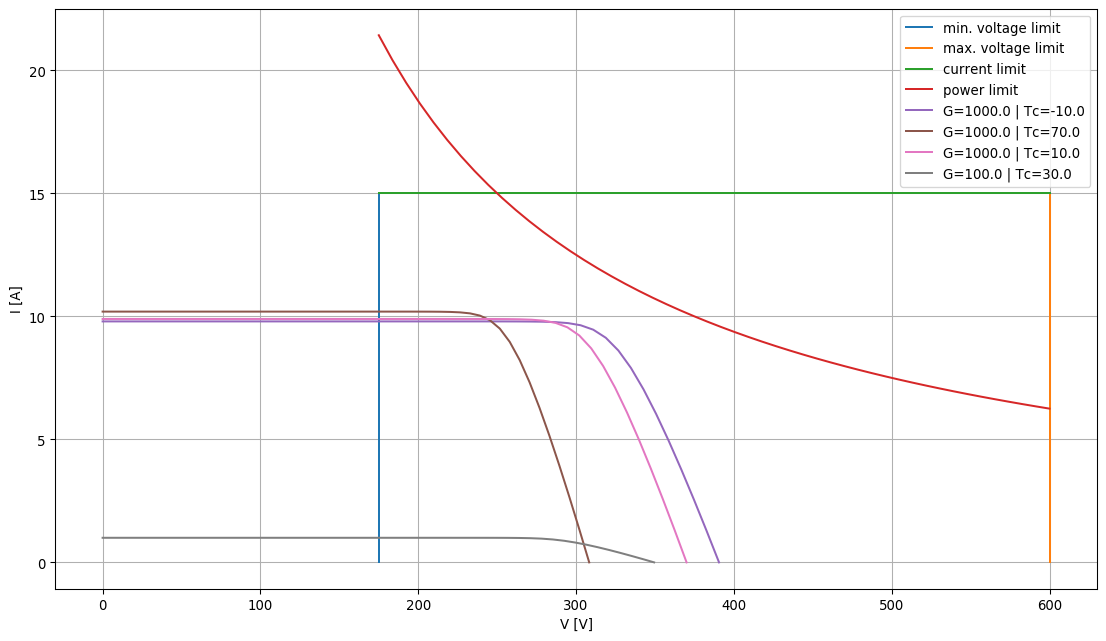

In [20]:
graph = inverter.plot_working_range(fig_size=(14, 8), dpi=96)
graph.show_graph()

De grafiek toont aan dat het MPP-punt van de FV matrix ook onder extreme externe condities binnen het werkingsgebied van de omvormer blijft (G = irradiantie, Tc = celtemperatuur).

**Omvormerrendement**<br>
Het omvormerrendement hangt af van de spanning en het vermogen. In de technische handleiding van de SMA omvormer worden deellastrendementen opgegeven bij drie verschillende spanningsniveaus. Wanneer men deze toevoert aan het computerprogramma, zal het bij de energieanalyse rekening kunnen houden met het reële rendement van de omvormer. 

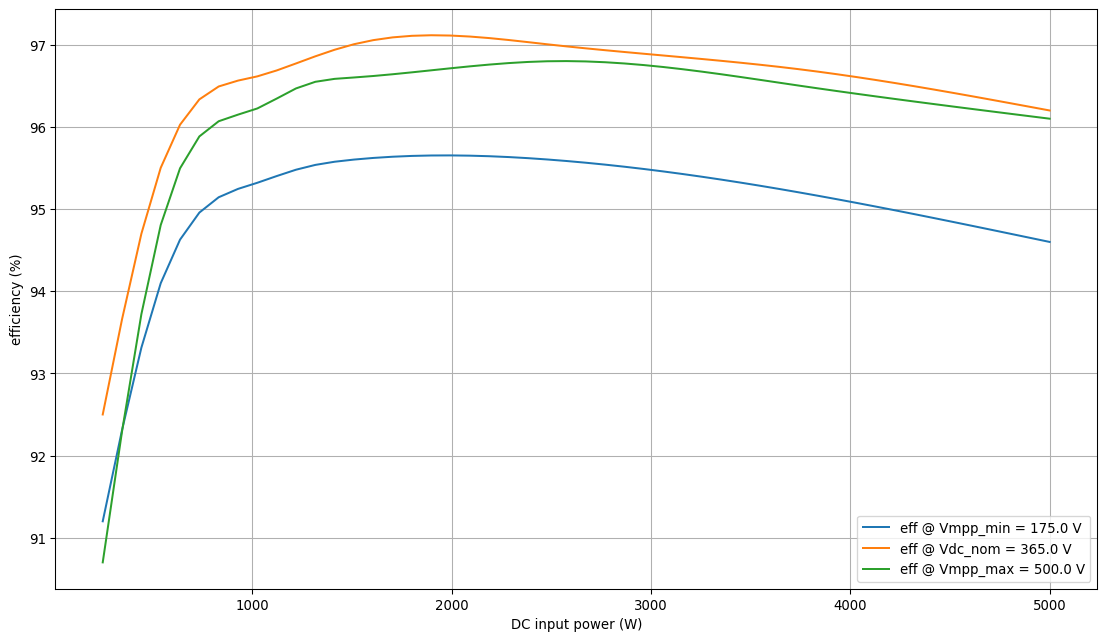

In [21]:
inverter.set_part_load_efficiencies(
    eff_at_Vmpp_min={5: 91.2, 10: 93.8, 20: 95.3, 25: 95.5, 30: 95.6, 50: 95.6, 75: 95.2, 100: 94.6},
    eff_at_Vdc_nom={5: 92.5, 10: 95.2, 20: 96.6, 25: 96.8, 30: 97.0, 50: 97.0, 75: 96.7, 100: 96.2},
    eff_at_Vmpp_max={5: 90.7, 10: 94.4, 20: 96.2, 25: 96.5, 30: 96.6, 50: 96.8, 75: 96.5, 100: 96.1}
)
graph = inverter.plot_efficiency_curves(fig_size=(14, 8), dpi=96)